# Advabced Python: Bike Sharing Prediction with DASK
## Individual Assignment
By Alejandro Fernández Campos

In [203]:
#Import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.metrics import r2_score
import dask.dataframe as dd 
import dask.array as da
from dask.distributed import Client 
import sklearn
import dask_ml
import matplotlib.pyplot as plt

In [190]:
#url = "https://github.com/alejandrofernandezcampos/Adv_Python_Dask/raw/master/hour.csv"
#hour_da = dd.read_csv(url,sep=";")

I couldt make the above method work to read with dask from url. It works with pandas though. Given that the main goal was working with Dask DataFrames we will read from the repository insted

Start reading data with Dask

In [172]:
hour_dd = dd.read_csv("./hour.csv")

Most of the operativity of pandas works with Dask

In [173]:
hour_dd.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [174]:
hour_dd.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

We will predict the count value as it is the sum of the casual and registered. This means we have to leave these values out for the modelling.

Additionally, instant and dteday are not statistically significant for predicting, so we remove them as well

In [175]:
hour_dd = hour_dd.drop(["instant", "casual", "registered"], axis=1)

In [176]:
hour_dd.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


Remove null values, if any

In [177]:
hour_dd = hour_dd.loc[-hour_dd.cnt.isnull(), :]

### Check correlation

In [178]:
corr = hour_dd.corr()

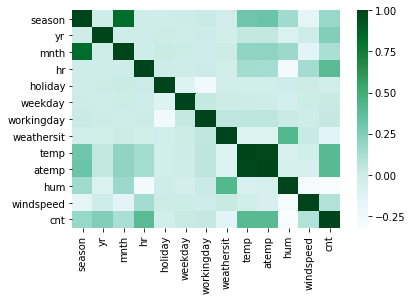

In [179]:
sns.heatmap(corr, cmap="BuGn", xticklabels=corr.columns, yticklabels=corr.columns)

We can see some very high correlation between temp and atemp. We remove atemp to avoid noise in our Linear Regression

In [180]:
hour_dd = hour_dd.drop(["atemp"], axis=1)

In [181]:
hour_dd.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


Remove outlayers in the variable to predict. Outlayers calculated as points 3 standard deviations away from the mean

In [182]:
hour_dd_no_outlayers = hour_dd[
    np.abs(hour_dd["hum"] - hour_dd["hum"].mean()) <= (3 * hour_dd["hum"].std())
]
print(f"{len(hour_dd)-len(hour_dd_no_outlayers)} outlayers removed")

22 outlayers removed


### Train Test split

We know that the we have to predict the cnt values from the first of October of 2012, so we identify this record to make our train/test split

In [183]:
test_starts = hour_dd_no_outlayers[hour_dd_no_outlayers["dteday"] == "2012-10-01"].head(
    1
)
index = test_starts.index
print(f"The test set, from 2012-10-01 on, starts in index {index[0]}")

The test set, from 2012-10-01 on, starts in index 15211


In [61]:
train = hour_dd_no_outlayers.loc[0 : index[0], :]
test = hour_dd_no_outlayers.loc[index[0] + 1 : len(hour_dd_no_outlayers["cnt"]), :]

percentage_data_used = len(test) / (len(train) + len(train))
print(f"{round((1-percentage_data_used)*100,2)}% of data for training")
print(f"{round(percentage_data_used*100,2)}% of data for testing")

92.94% of data for training
7.06% of data for testing


We get rid of dteday since it has no statistical relevance for predicting and differentiate predictors from label

In [63]:
train_X = train.loc[:, "season":"windspeed"]
train_y = train.loc[:, "cnt"]
# Instead of pandas shape we use len() of the Dask Dataframe
test_X = test.loc[:, "season":"windspeed"]
test_y = test.loc[:, "cnt"]

### First Prediction: Dask Linear Regresor

After some trial and error, the solution was using the method values

In [67]:
from dask_ml.linear_model import LinearRegression

LR = LinearRegression()

LR_model_baseline = LR.fit(train_X.values, train_y.values)

LR_baseline_predicted = LR_model_baseline.predict(test_X.values)

I was not able to make the DASK metrics library to work, alternatively I use sklearn metrics

In [72]:
from sklearn import metrics

score = metrics.r2_score(
    y_true=np.array(test_y), y_pred=np.array(LR_baseline_predicted)
)

print(f"Score using Dask LR: {round(score,3)}")

Score using Dask LR: 0.29


### Get dummies

We see from the R squared that we obtain limited results with direct LR. We will encode our categorical variables to find a better result. We select the ones that are "categorical" meaning that even being numerical variables its meaning is not numeric

In [86]:
to_bin = hour_dd_no_outlayers[["season", "yr", "mnth", "hr", "weekday", "weathersit"]]

After a long trial with OneHotEncoder, using the method .categorize() first and then using the method .getdummies works.

In [93]:
to_bin.season = to_bin.season.astype("category")
to_bin.yr = to_bin.yr.astype("category")
to_bin.mnth = to_bin.mnth.astype("category")
to_bin.hr = to_bin.hr.astype("category")
to_bin.weekday = to_bin.weekday.astype("category")
to_bin.weathersit = to_bin.weathersit.astype("category")


to_bin = to_bin.categorize()

dummified = dd.get_dummies(to_bin)

dummies = dummified

We add back the values of our numeric variables. For doing this we re set the index to the original one. Otherwise we find problems when adding the variables from the old datase

In [94]:
dummies["temp"] = hour_dd_no_outlayers["temp"]
dummies["hum"] = hour_dd_no_outlayers["hum"]
dummies["windspeed"] = hour_dd_no_outlayers["windspeed"]

Train test split again

In [118]:
train_dummies = dummies.loc[0 : index[0], :]
test_dummies = dummies.loc[index[0] + 1 : len(dummies["temp"]), :]

In [119]:
LR = LinearRegression()
LR_model_dummy = LR.fit(train_dummies.values,train_y.values)

In [120]:
predictions_dummy = LR_model_dummy.predict(test_dummies.values)

In [135]:
score = metrics.r2_score(y_true=np.array(test_y), y_pred=np.array(predictions_dummy))

print(f"R^2 Score using Dask LR and dummified categories: {round(score,3)}")

R^2 Score using Dask LR and dummified categories: 0.635


### Scaling numeric features

So we see that the Dummifying, as expected, improves the prediction thoroughly. Now the next step will me normalizing our numeric variables and check the results.

In [125]:
from dask_ml.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

to_scale = hour_dd_no_outlayers[["hum", "temp", "windspeed"]]

scaled = scaler.fit_transform(to_scale)

Now we add the new scaled features to the sparse matrix with the dummified version of our categories. We scale down the sparse matrix for giving more importance to the scaled numeric features

In [143]:
scaled_dummies = dummified * 0.7
scaled_dummies["temp"] = scaled["temp"]
scaled_dummies["hum"] = scaled["hum"]
scaled_dummies["windspeed"] = scaled["windspeed"]

Train test again

In [144]:
train_scal_dummies = scaled_dummies.loc[0:index[0], :]
test_scal_dummies = scaled_dummies.loc[index[0]+1 : len(dummies["temp"]), :]

In [145]:
LR = LinearRegression()
LR_model_dummy = LR.fit(train_scal_dummies.values, train_y.values)

predictions_dummy = LR_model_dummy.predict(test_scal_dummies.values)

score = metrics.r2_score(y_true=np.array(test_y), y_pred=np.array(predictions_dummy))

print(f"R^2 Score using Dask LR and dummified categories: {round(score,3)}")

R^2 Score using Dask LR and dummified categories: 0.635


No significan improvement 

### Random forest

We will run the random forest model first in sklearn and dask dataframes and scale it later using Client

In [155]:
type(train_scal_dummies)

dask.dataframe.core.DataFrame

In [151]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(train_scal_dummies, train_y)
predictions = regressor.predict(test_scal_dummies)

score = metrics.r2_score(y_true=test_y, y_pred=predictions)

print(f"R^2 Score using Dask LR and dummified categories: {round(score,3)}")

/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2 Score using Dask LR and dummified categories: 0.793


### Random Forest and Client

The best Dask operativity is distributing work across different computing units. The client function allow us connecting to a cluster. However, given that I had not the time go set up a cluster I am using client in my own computer, which wuould distribute work around cores. Alternativelly, to connect to a cluster you could just pass the ip and the port istead of (processes=False).

In [229]:
from dask.distributed import Client

client = Client(processes=False)


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

regressor = RandomForestRegressor()
parameters = [
    {"n_estimators": [150, 200, 250, 300], "max_features": ["auto", "sqrt", "log2"]}
]

grid_search = GridSearchCV(estimator=regressor, param_grid=parameters, n_jobs=-1)

with client:
    grid_search = grid_search.fit(
        np.array(train_scal_dummies), np.array(train_y)
    )
    predictions = grid_search.predict(np.array(test_scal_dummies))
    score = metrics.r2_score(y_true=np.array(test_y), y_pred=np.array(predictions))
    print(f"Score using GridSearch and Random Forest: {round(score,3)}")

/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:14: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  "\nDask needs bokeh >= 0.13.0 for the dashboard."
/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Score using GridSearch and Random Forest: 0.808


### Gradient Boost and Client

We will take advantage of the client paralellization to load a hevier grid search for a GradientBoostingRegressor

In [159]:
from sklearn.ensemble import GradientBoostingRegressor

client = Client(processes=False)

regressor = GradientBoostingRegressor()
parameters = [
    {
        "n_estimators": [1000,3000],
        "learning_rate": [0.1,0.01],
        "alpha": [0.3, 0.6, 0.8],
    }
]

grid_search = GridSearchCV(estimator=regressor, param_grid=parameters, n_jobs=-1)

with client:
    grid_search = grid_search.fit(
        np.array(train_scal_dummies), np.array(train_y)
    )
    predictions = grid_search.predict(np.array(test_scal_dummies))
    score = metrics.r2_score(y_true=np.array(test_y), y_pred=np.array(predictions))
    print(f"Score using GridSearch and Gradient Boost Regressor: {round(score,3)}")

/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:14: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  "\nDask needs bokeh >= 0.13.0 for the dashboard."
/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Score using GridSearch and Gradient Boost Regressor: 0.8536829614690988


We will use the best parameters from this gridsearch for the final model

In [192]:
grid_search.best_params_

{'alpha': 0.3, 'learning_rate': 0.1, 'n_estimators': 3000}

### Wrapping all together in a Pipeline and running parallely

We wrap up here the steps we have followed in a Pipeline. To do that, we buid 2 functions: get dummies and scale numeric variables. This is built with the TransformerMix function, as pipelines only work with transformers along the pipeline and a fit_transform at the end.

In [193]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer

from sklearn.base import TransformerMixin


class getDummies(TransformerMixin):
    def __init__(self, cat):
        self.cat = cat

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        to_bin = X[cat]
        to_bin = to_bin.categorize()
        return dd.get_dummies(to_bin)


class getScaledFeatures(TransformerMixin):
    def __init__(self, num):
        self.cat = cat

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        from dask_ml.preprocessing import MinMaxScaler

        to_scale = X[num]
        scaler = MinMaxScaler()
        return scaler.fit_transform(to_scale)

In [195]:
from sklearn.pipeline import FeatureUnion

num = ["hum", "temp", "windspeed"]

cat = ["season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]

pipe = make_pipeline(
    FeatureUnion([("dummy", getDummies(cat)), ("scale", getScaledFeatures(num))]),
    GradientBoostingRegressor(alpha=0.6, learning_rate=0.1, n_estimators=3000),
)

client = Client(processes=False)
with client:
    pipe.fit(train, train_y)
    predicador = pipe.predict(test)
    score = r2_score(y_pred=predicador,y_true=test["cnt"])
    print(f"Score using Pipeline and Gradient Boost Regressor: {round(score,3)}")

/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:14: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  "\nDask needs bokeh >= 0.13.0 for the dashboard."


Score using GridSearch and Gradient Boost Regressor: 0.8466085138582511


### Visualizing results

Plot the different density of the predicted and real values of "count"

/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/alejandrofernandez/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


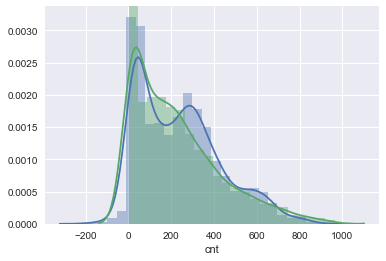

In [211]:
sns.set_style("darkgrid")
sns.distplot(predicador)
sns.distplot(test_y)
plt.show()

Plot the actual predicted and real values, had to convert Dask to numpy to be able to see it

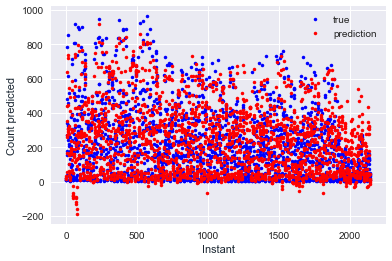

In [225]:
fig = plt.figure()
plt.plot(np.array(test["cnt"]),'.b', label='true')
plt.plot(np.array(predicador), '.r', label='prediction')
plt.xlabel('Instant', color='#1C2833')
plt.ylabel('Count predicted', color='#1C2833')
plt.legend(loc='upper right')
plt.show()